In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/creditcard.csv


In [2]:
!pip install -U scikit-learn imbalanced-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 28.6 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
category-encoders 2.7.0 requires scikit-learn<1.6.0,>=1.0.0, but you have scikit-learn 1.6.1 which is incompatible.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.


In [3]:
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    accuracy_score,
    recall_score
)

from imblearn.over_sampling import SMOTE


**Download Dataset using kagglehub**

In [4]:
path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")
print("✅ Download complete. Path to dataset files:", path)


✅ Download complete. Path to dataset files: /kaggle/input/


**Load & Explore Dataset**

In [5]:
df = pd.read_csv(path + "/creditcard.csv")
print("✅ Dataset loaded successfully.\n")
print(df.head())

print("\n🔢 Class distribution:")
print(df['Class'].value_counts())

✅ Dataset loaded successfully.

   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   



**Data Preprocessing**

In [6]:
# Standardize 'Amount' feature
df['Amount'] = StandardScaler().fit_transform(df[['Amount']])

# Separate features and target
X = df.drop(['Class', 'Time'], axis=1)
y = df['Class']

# Split with stratification to keep class distribution
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"\nTraining class distribution before SMOTE: {np.bincount(y_train)}")



Training class distribution before SMOTE: [199020    344]


**Apply SMOTE to Balance Training Data**

In [7]:
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print(f"Training class distribution after SMOTE: {np.bincount(y_train_res)}")


Training class distribution after SMOTE: [199020 199020]


**Train Random Forest Model**

In [8]:
rfc_smote = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight='balanced'  # still helpful even after SMOTE
)
rfc_smote.fit(X_train_res, y_train_res)

print("\nModel trained with SMOTE balanced data.")



Model trained with SMOTE balanced data.


**Evaluate Model with Default Threshold (0.5)**


Classification report with default threshold (0.5):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.87      0.78      0.82       148

    accuracy                           1.00     85443
   macro avg       0.93      0.89      0.91     85443
weighted avg       1.00      1.00      1.00     85443



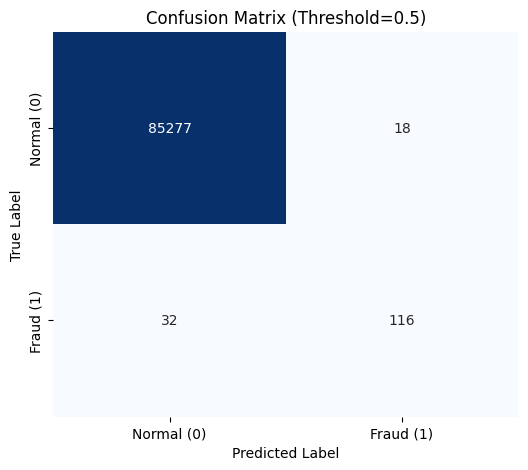

In [9]:
y_probs_smote = rfc_smote.predict_proba(X_test)[:, 1]
y_pred_default = (y_probs_smote >= 0.5).astype(int)

print("\nClassification report with default threshold (0.5):")
print(classification_report(y_test, y_pred_default))

cm_default = confusion_matrix(y_test, y_pred_default)
plt.figure(figsize=(6,5))
sns.heatmap(cm_default, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Normal (0)', 'Fraud (1)'],
            yticklabels=['Normal (0)', 'Fraud (1)'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Threshold=0.5)')
plt.show()


**Tune Threshold to Improve Recall**


Classification report with adjusted threshold (0.3):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.72      0.83      0.77       148

    accuracy                           1.00     85443
   macro avg       0.86      0.92      0.89     85443
weighted avg       1.00      1.00      1.00     85443

Recall at threshold 0.3: 0.8311


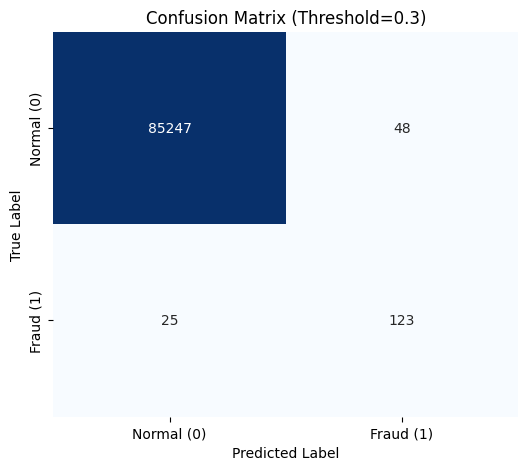

In [10]:
threshold = 0.3  # Lower threshold to catch more fraud cases

y_pred_adjusted = (y_probs_smote >= threshold).astype(int)

print(f"\nClassification report with adjusted threshold ({threshold}):")
print(classification_report(y_test, y_pred_adjusted))

recall = recall_score(y_test, y_pred_adjusted)
print(f"Recall at threshold {threshold}: {recall:.4f}")

cm_adj = confusion_matrix(y_test, y_pred_adjusted)
plt.figure(figsize=(6,5))
sns.heatmap(cm_adj, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Normal (0)', 'Fraud (1)'],
            yticklabels=['Normal (0)', 'Fraud (1)'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Confusion Matrix (Threshold={threshold})')
plt.show()


**Feature Importance Visualization**

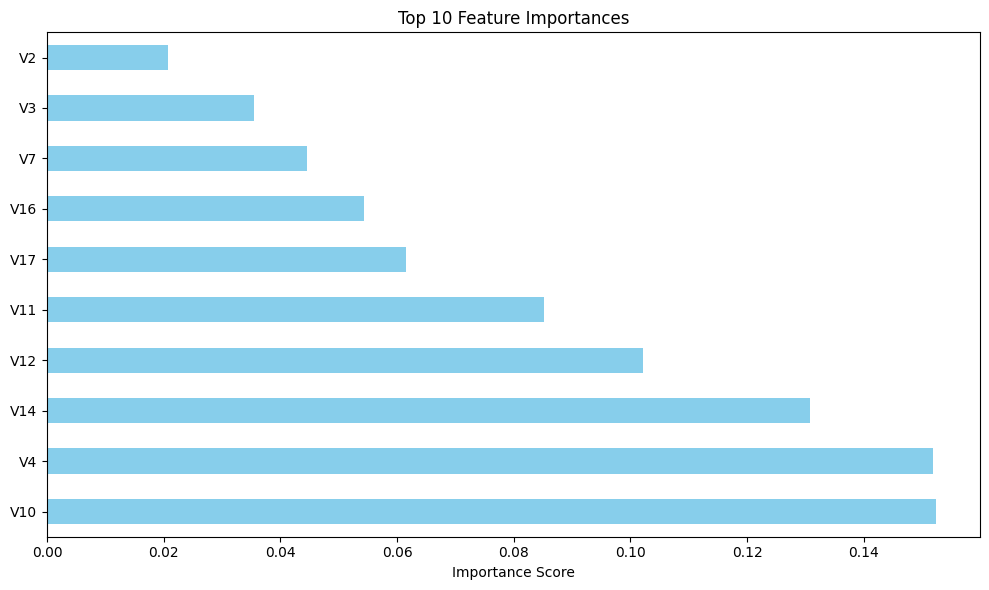

In [11]:
feature_importances = pd.Series(rfc_smote.feature_importances_, index=X.columns)
plt.figure(figsize=(10, 6))
feature_importances.nlargest(10).plot(kind='barh', color='skyblue')
plt.title("Top 10 Feature Importances")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

**Class Imbalance Bar Plot**

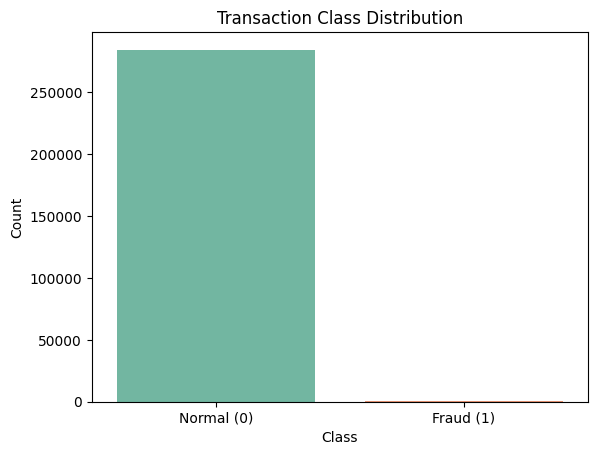

In [12]:
# Plot class distribution
sns.countplot(data=df, x='Class', palette='Set2')
plt.title("Transaction Class Distribution")
plt.xticks([0, 1], ['Normal (0)', 'Fraud (1)'])
plt.ylabel("Count")
plt.show()


**Correlation Heatmap of Top Features**

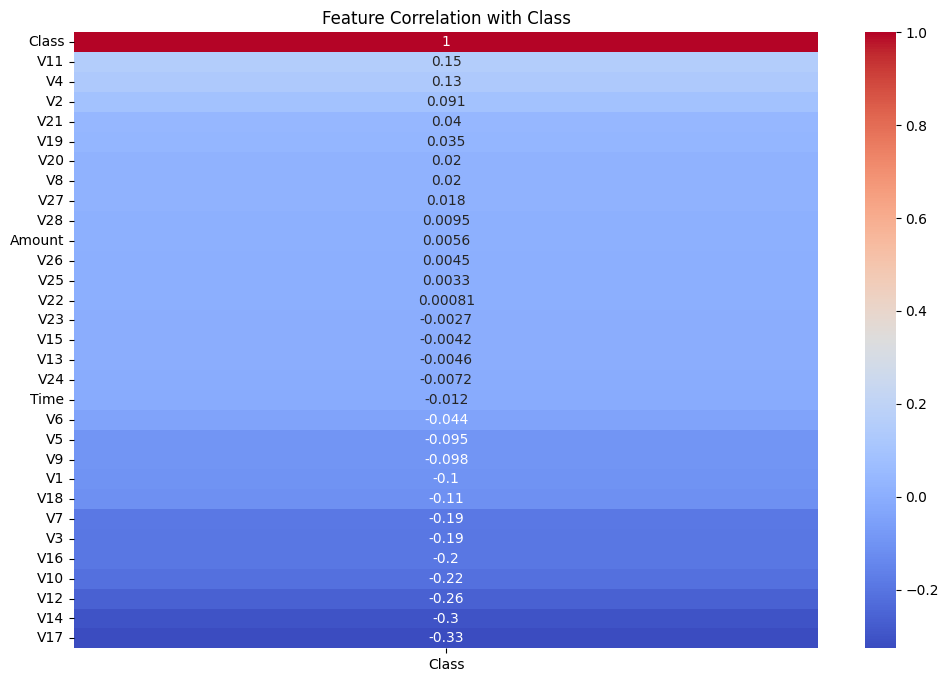

In [13]:
# Compute correlation and plot heatmap
corr = df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr[['Class']].sort_values(by='Class', ascending=False), annot=True, cmap='coolwarm')
plt.title("Feature Correlation with Class")
plt.show()


**Full Correlation Matrix**

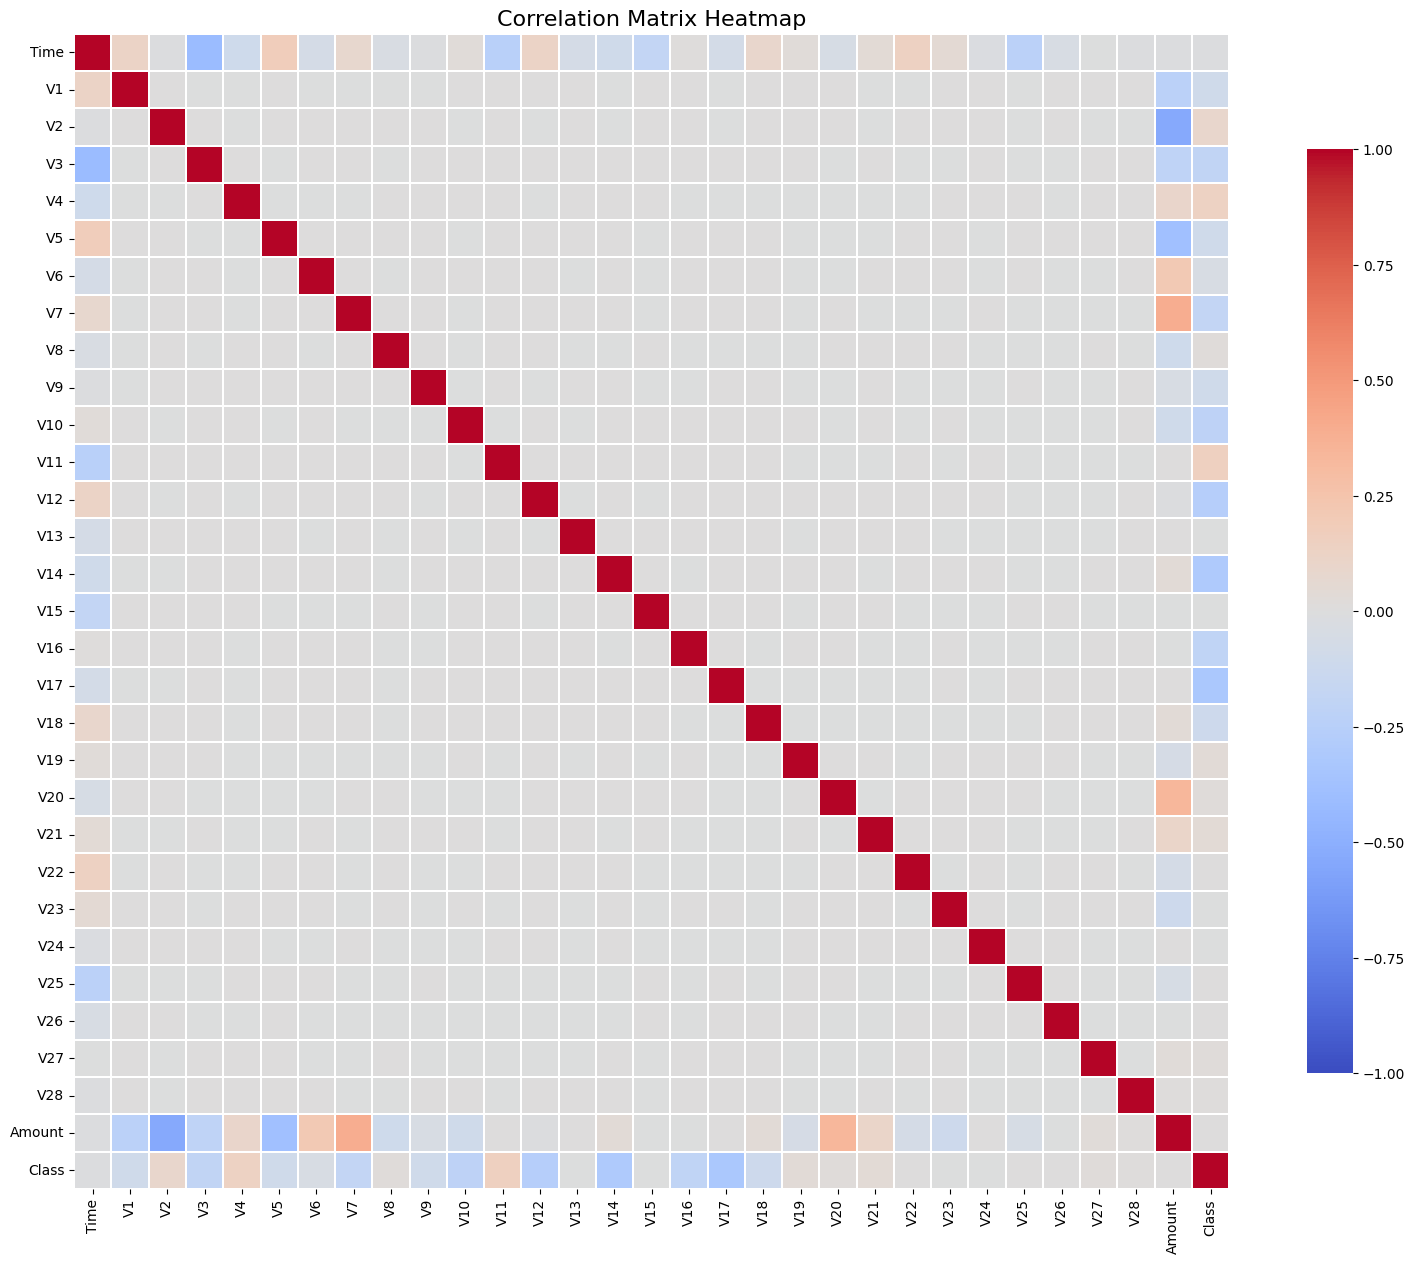

In [14]:
#  Full Correlation Matrix
plt.figure(figsize=(20, 15))
corr_matrix = df.corr()

sns.heatmap(
    corr_matrix,
    cmap='coolwarm',
    vmin=-1,
    vmax=1,
    annot=False,
    fmt=".2f",
    linewidths=0.2,
    square=True,
    cbar_kws={"shrink": 0.8}
)

plt.title("Correlation Matrix Heatmap", fontsize=16)
plt.show()


In [15]:
#  Top correlations with Class
top_corr = corr_matrix['Class'].abs().sort_values(ascending=False)[1:11]  # top 10 excluding 'Class' itself
print("Top correlated features with 'Class':\n", top_corr)


Top correlated features with 'Class':
 V17    0.326481
V14    0.302544
V12    0.260593
V10    0.216883
V16    0.196539
V3     0.192961
V7     0.187257
V11    0.154876
V4     0.133447
V18    0.111485
Name: Class, dtype: float64
